In [1]:
experiment_name = '25similar'
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

Setting up variables & DB connection for experiment:

*******************
25similar
*******************

Snorkel session connected to:  postgres:///snorkel25similar


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
train = session.query(REGULATOR).filter(REGULATOR.split == 0).order_by(REGULATOR.id).all()
dev = session.query(REGULATOR).filter(REGULATOR.split == 1).order_by(REGULATOR.id).all()
test = session.query(REGULATOR).filter(REGULATOR.split == 2).order_by(REGULATOR.id).all()
unlab = session.query(REGULATOR).filter(REGULATOR.split == 3).order_by(REGULATOR.id).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))
print('Unlab set:\t{0} candidates'.format(len(unlab)))

Training set:	13007 candidates
Dev set:	3242 candidates
Test set:	8221 candidates
Unlab set:	23509 candidates


In [3]:
from snorkel.annotations import load_gold_labels

L_gold_train  = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [4]:
import numpy as np
from snorkel.annotations import load_marginals

In [5]:
unlab_marginals = load_marginals(session, split=3) # safe - loads them after ordering by candidate id

In [6]:
# just to make sure that it keeps consistency
train_labels = np.array([0 if train[x].gold_labels[0].value ==-1 else 1 for x in range(len(train))]) # load train labels to mix in LSTM
dev_labels = np.array([0 if dev[x].gold_labels[0].value ==-1 else 1 for x in range(len(dev))]) # load train labels to mix in LSTM
test_labels = np.array([0 if test[x].gold_labels[0].value ==-1 else 1 for x in range(len(test))]) # load train labels to mix in LSTM

In [7]:
np.__version__

'1.14.5'

In [8]:
from snorkel.learning import reRNN

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
from MLutils import balance_candidates

In [10]:
# unlab_us,unlab_marginals_us = balance_candidates(unlab,unlab_marginals)

# # TODO: balance candidates also in training set (change train_unlab_marginals below + train -> train_us in lstm.train)
train_us, train_labels_us = balance_candidates(train,train_labels)

train_unlab_marginals = np.append(train_labels_us, unlab_marginals)

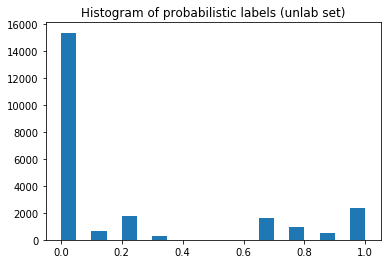

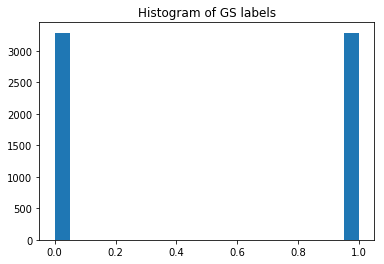

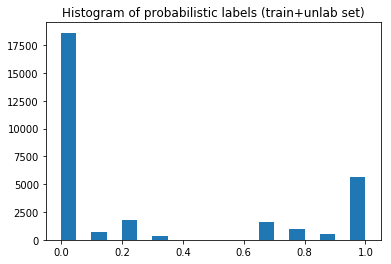

In [11]:
import matplotlib.pyplot as plt
plt.hist(unlab_marginals, bins=20, range=[0,1])
plt.title('Histogram of probabilistic labels (unlab set)')
plt.show()

import matplotlib.pyplot as plt
plt.hist(train_labels_us, bins=20, range=[0,1])
plt.title('Histogram of GS labels')
plt.show()

# plt.hist(unlab_marginals_us, bins=20, range=[0,1])
# plt.title('Histogram of probabilistic labels (unlab set, undersampled)')
# plt.show()

# plt.hist(train_labels_us, bins=20)
# plt.title('Histogram of labels (train set)')
# plt.show()

plt.hist(train_unlab_marginals, bins=20)
plt.title('Histogram of probabilistic labels (train+unlab set)')
plt.show()


** train on train_set (to see if all ok or theres a mess-up in labels) **

In [12]:
len(train)

13007

In [13]:
train_labels.shape

(13007,)

In [16]:
L_gold_dev.todense()

matrix([[-1],
        [-1],
        [-1],
        ...,
        [ 1],
        [-1],
        [-1]])

In [17]:
dev_labels

array([0, 0, 0, ..., 1, 0, 0])

** train on training **

In [23]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0
}

lstm = reRNN(seed=1701, deterministic=True)
lstm.train(train, train_labels, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6576  #epochs=10  batch size=64
[reRNN] Epoch 0 (25.59s)	Average loss=0.572058	Dev F1=48.56
[reRNN] Epoch 1 (55.05s)	Average loss=0.357547	Dev F1=51.71
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (83.44s)	Average loss=0.262779	Dev F1=47.70
[reRNN] Epoch 3 (111.20s)	Average loss=0.202796	Dev F1=49.22
[reRNN] Epoch 4 (139.57s)	Average loss=0.151993	Dev F1=51.00
[reRNN] Epoch 5 (167.06s)	Average loss=0.123686	Dev F1=52.72
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (195.02s)	Average loss=0.091535	Dev F1=53.15
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (222.96s)	Average loss=0.069518	Dev F1=50.65
[reRNN] Epoch 8 (250.77s)	Average loss=0.056904	Dev F1=51.18
[reRNN] Epoch 9 (278.54s)	Average loss=0.049904	Dev F1=50.00
[reRNN] Training done (282.33s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-6
[reRNN] Loaded model <reRNN>


In [24]:
lstm.score(dev,L_gold_dev)

(0.4569402228976697, 0.6352112676056338, 0.5315262227460225)

In [25]:
lstm.score(dev,dev_labels)

(0.4569402228976697, 0.6352112676056338, 0.5315262227460225)

In [26]:
lstm.score(test,L_gold_test,batch_size=32)

(0.5132743362831859, 0.6139112903225806, 0.5591002983704384)

In [27]:
lstm.score(test,test_labels,batch_size=64)

(0.5132743362831859, 0.6139112903225806, 0.5591002983704384)

** train on unlab **

In [38]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   35,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0
}

lstm = reRNN(seed=1701, deterministic=True)
lstm.train(unlab, unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=10786  #epochs=35  batch size=64
[reRNN] Epoch 0 (29.66s)	Average loss=0.605242	Dev F1=39.39
[reRNN] Epoch 1 (62.07s)	Average loss=0.441300	Dev F1=36.97
[reRNN] Epoch 2 (94.42s)	Average loss=0.358777	Dev F1=37.20
[reRNN] Epoch 3 (126.68s)	Average loss=0.326538	Dev F1=38.69
[reRNN] Epoch 4 (158.80s)	Average loss=0.309259	Dev F1=40.40
[reRNN] Epoch 5 (191.24s)	Average loss=0.295640	Dev F1=39.77
[reRNN] Epoch 6 (223.55s)	Average loss=0.286219	Dev F1=38.31
[reRNN] Epoch 7 (255.60s)	Average loss=0.280151	Dev F1=39.34
[reRNN] Epoch 8 (287.53s)	Average loss=0.272821	Dev F1=41.00
[reRNN] Epoch 9 (319.84s)	Average loss=0.268550	Dev F1=39.86
[reRNN] Epoch 10 (351.62s)	Average loss=0.266627	Dev F1=40.16
[reRNN] Epoch 11 (383.94s)	Average loss=0.263585	Dev F1=41.28
[reRNN] Epoch 12 (416.03s)	Average loss=0.258636	Dev F1=41.27
[reRNN] Epoch 13 (448.12s)	Average loss=0.255536	Dev F1=40.86
[reRNN] Epoch 14 (480.49s)	Average loss=0.253268	Dev F1=41.30
[reRNN] Epo

In [18]:
lstm.score(dev,L_gold_dev)

(0.3263888888888889, 0.5957746478873239, 0.4217347956131605)

In [19]:
lstm.score(dev,dev_labels)

(0.3263888888888889, 0.5957746478873239, 0.4217347956131605)

In [22]:
lstm.score(test,L_gold_test,batch_size=1024)

(0.34204733076499727, 0.6265120967741935, 0.4425062299750801)

In [23]:
lstm.score(test,test_labels,batch_size=1024)

(0.34204733076499727, 0.6265120967741935, 0.4425062299750801)

In [41]:
# reduce LR
# what happens with training loss????
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0
}

lstm = reRNN(seed=1701, deterministic=True)
lstm.train(unlab, unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=10786  #epochs=30  batch size=64
[reRNN] Epoch 0 (42.24s)	Average loss=0.586706	Dev F1=45.27
[reRNN] Epoch 1 (87.74s)	Average loss=0.459238	Dev F1=47.06
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (133.41s)	Average loss=0.398579	Dev F1=44.79
[reRNN] Epoch 3 (179.03s)	Average loss=0.361436	Dev F1=43.49
[reRNN] Epoch 4 (224.62s)	Average loss=0.337766	Dev F1=43.32
[reRNN] Epoch 5 (270.23s)	Average loss=0.321387	Dev F1=42.31
[reRNN] Epoch 6 (315.95s)	Average loss=0.311192	Dev F1=41.73
[reRNN] Epoch 7 (363.12s)	Average loss=0.304481	Dev F1=40.17
[reRNN] Epoch 8 (409.29s)	Average loss=0.295657	Dev F1=44.38
[reRNN] Epoch 9 (458.38s)	Average loss=0.290723	Dev F1=42.48
[reRNN] Epoch 10 (504.90s)	Average loss=0.286491	Dev F1=41.82
[reRNN] Epoch 11 (551.70s)	Average loss=0.283690	Dev F1=42.00
[reRNN] Epoch 12 (600.30s)	Average loss=0.282432	Dev F1=43.33
[reRNN] Epoch 13 (647.07s)	Average loss=0.278338	Dev F1=41.58
[reRNN] Epoch 14 (693.12s)	Average loss=0

In [42]:
lstm.score(dev,L_gold_dev)

(0.3984375, 0.5746478873239437, 0.4705882352941177)

In [43]:
lstm.score(dev,dev_labels)

(0.3984375, 0.5746478873239437, 0.4705882352941177)

In [44]:
lstm.score(test,L_gold_test,batch_size=32)

(0.36807028173280826, 0.6123991935483871, 0.45979186376537373)

In [45]:
lstm.score(test,test_labels,batch_size=1024)

(0.36807028173280826, 0.6123991935483871, 0.45979186376537373)

In [46]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.575
Neg. class accuracy: 0.757
Precision            0.398
Recall               0.575
F1                   0.471
----------------------------------------
TP: 408 | FP: 616 | TN: 1916 | FN: 302



In [47]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test,batch_size=1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.612
Neg. class accuracy: 0.666
Precision            0.368
Recall               0.612
F1                   0.46
----------------------------------------
TP: 1215 | FP: 2086 | TN: 4151 | FN: 769



** train on GS + unlab **

In [48]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0
}

lstm = reRNN(seed=1701, deterministic=True)
lstm.train(train+unlab, 
           np.concatenate([train_labels ,unlab_marginals]),
           X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=17362  #epochs=30  batch size=64
[reRNN] Epoch 0 (69.73s)	Average loss=0.578129	Dev F1=46.19
[reRNN] Epoch 1 (142.83s)	Average loss=0.408952	Dev F1=46.51
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (216.47s)	Average loss=0.336897	Dev F1=47.01
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (290.66s)	Average loss=0.300556	Dev F1=44.67
[reRNN] Epoch 4 (364.92s)	Average loss=0.270693	Dev F1=46.98
[reRNN] Epoch 5 (437.66s)	Average loss=0.255940	Dev F1=41.30
[reRNN] Epoch 6 (511.74s)	Average loss=0.244919	Dev F1=46.54
[reRNN] Epoch 7 (586.26s)	Average loss=0.234462	Dev F1=43.72
[reRNN] Epoch 8 (661.69s)	Average loss=0.224339	Dev F1=43.22
[reRNN] Epoch 9 (735.39s)	Average loss=0.221312	Dev F1=45.94
[reRNN] Epoch 10 (811.10s)	Average loss=0.216153	Dev F1=45.51
[reRNN] Epoch 11 (884.63s)	Average loss=0.215942	Dev F1=42.90
[reRNN] Epoch 12 (956.75s)	Average loss=0.213279	Dev F1=44.98
[reRNN] Epoch 13 (1032.44s)	Average loss=0.203226	Dev F1=46.29
[reRNN] 

In [49]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.634
Neg. class accuracy: 0.717
Precision            0.386
Recall               0.634
F1                   0.479
----------------------------------------
TP: 450 | FP: 717 | TN: 1815 | FN: 260



In [50]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.681
Neg. class accuracy: 0.676
Precision            0.401
Recall               0.681
F1                   0.505
----------------------------------------
TP: 1351 | FP: 2019 | TN: 4218 | FN: 633

